In [36]:
import sys
import os
import pandas as pd
from pytablewriter import MarkdownTableWriter
from typing import Dict, List, Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

%config Completer.use_jedi = False


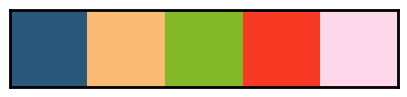

In [2]:

sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context("paper", font_scale=1.5)

plt.rcParams.update({'axes.edgecolor': 'black', 'axes.linewidth': 2, 
                     'axes.grid': False, 'grid.linestyle': '--'})
colors = ['#2A587A', '#FABC75', '#83B828', '#F83A25', '#FDD8EB']
sns.palplot(colors)
sns.set_palette(sns.color_palette(colors), 8, .75)
sub_figure_title = {"fontweight": 700, 'fontname':'Arial', 'fontsize': 18}
#plt.tight_layout()


In [3]:
#ALGORITHM = ["semantic-zest", "syntactic-zest", "semantic-noguidance", "syntactic-noguidance"]
ALGORITHM = ["semantic-zest", "syntactic-zest", "semantic-noguidance", "syntactic-noguidance","afl"]

RANGE=20 #exclusiove range in python


In [4]:
#path = "/home/alena/source/growe/exps8"
base_path = "c:\\Users\\Alena\\source\\repos\\growe\\exps8\\"
folder = "exps8"


In [5]:

def process_cov_data(path: str) -> List[str]:
    with open(path) as f:
        return f.readlines()

def add_rolling_mean( data : pd.DataFrame, rolling : int = 10) -> pd.DataFrame:
    
    # rolling mean to valid_covered_probes
    data[f'rolling_{rolling}_valid_covered_probes'] = data['valid_covered_probes'].rolling(rolling).mean()
    
    # rolling mean to all_covered_probes
    data[f'rolling_{rolling}_all_covered_probes'] = data['all_covered_probes'].rolling(rolling).mean()
    
    # rolling mean to total_inputs
    data[f'rolling_{rolling}_total_inputs'] = data['total_inputs'].rolling(rolling).mean()
   
    return data

In [6]:
def read_plot_data(path: str, algorithm: str) -> pd.DataFrame:
    ps=os.path.join(path, 'plot_data')
    #print(ps)
    time_axis = "# unix_time"
    threshhold=3600 #seconds	
    if algorithm == "afl":
        data = pd.read_csv(ps, sep=",", skipinitialspace=True,
                       converters={"valid_cov": p2f, "map_size": p2f})
    else:
        data = pd.read_csv(ps, sep=",", skipinitialspace=True)

    if data.empty: return None

    data[time_axis] -= data[time_axis][0]
    data['total_inputs'] = data['valid_inputs'] + data['invalid_inputs']
    data['total_inputs'] -= data["total_inputs"][0]
    
    data = data[data[time_axis] < threshhold]

    x_axis = time_axis
    algo_data = data.copy().drop_duplicates(
        keep='first', subset=[x_axis])
    
    algo_data['algorithm'] = [algorithm] * algo_data.shape[0]
  
    return algo_data


In [7]:
#read cov-all and cov-valid

cov_data_count = {
    "algo": [],
    "type": [],
    "value": []
}

cov_all_data = []
cov_valid_data = []

def read_this(path, typ):
    cov = process_cov_data(path)
    cov_data_count["algo"].append(algorithm)
    cov_data_count["type"].append(typ)
    cov_data_count["value"].append(len(cov))

    if len(cov) > 0: 
        splits = [c.replace('# Covered: (','').split(') ') for c in cov]
        data = np.array(splits)
        cov,calls = data.T
        method=[c.split('()')[0] for c in calls]
        clazz=[c.split('#')[0] for c in method]
        clazz=[c.split('$')[0] for c in clazz]
        
        cov_int = [int(i) for i in cov]
        
        df=pd.DataFrame({'cov':cov_int, 'clazz':clazz,'method':method,'calls':calls})
        df['clazz'] = pd.Categorical(df['clazz'], categories=set(clazz))
        df['method'] = pd.Categorical(df['method'], categories=set(method))
        
        
        #df.columns = ['cov','class']
        df['algorithm']=[algorithm]*len(cov)

        return df
    return pd.DataFrame()
        

for algorithm in ALGORITHM:
    cov_all_data_algo = []
    cov_valid_data_algo = []

    for idx in range(0, RANGE):
        path = os.path.join(base_path, f"nextflow-{algorithm}-{idx}", "errorDir")
        if algorithm == "afl":
            path = os.path.join(base_path, f"nextflow-{algorithm}-{idx}","fuzz-results")
        if not os.path.exists(path):
            continue
        #print(f"processing: {path}")

        #read cov all
        cov_all_path = os.path.join(path, "cov-all.log")
        if not os.path.exists(cov_all_path): continue
        
        df = read_this(cov_all_path,"all")
        if not df.empty: cov_all_data_algo.append(df)

        
        #read cov valid
        cov_valid_path = os.path.join(path, "cov-valid.log")
        if not os.path.exists(cov_valid_path): continue
        
        df = read_this(cov_valid_path,"valid")
        if not df.empty: cov_valid_data_algo.append(df)

    
    cov_valid_data.append(pd.concat( cov_valid_data_algo))
    cov_all_data.append(pd.concat( cov_all_data_algo))
    

In [8]:
    
cov_valid_data = pd.concat( cov_valid_data)
cov_all_data = pd.concat( cov_all_data)

In [9]:
cov_valid_data[0:20]



,cov,clazz,method,calls,algorithm
0,-7909373,nextflow/extension/OperatorImpl,nextflow/extension/OperatorImpl#$getCallSiteArray,nextflow/extension/OperatorImpl#$getCallSiteAr...,semantic-zest
1,-7909375,nextflow/extension/OperatorImpl,nextflow/extension/OperatorImpl#$getCallSiteArray,nextflow/extension/OperatorImpl#$getCallSiteAr...,semantic-zest
2,-7929855,nextflow/extension/OperatorImpl,nextflow/extension/OperatorImpl#getMetaClass,nextflow/extension/OperatorImpl#getMetaClass()...,semantic-zest
3,-8060924,nextflow/extension/OperatorImpl,nextflow/extension/OperatorImpl#multiMap,nextflow/extension/OperatorImpl#multiMap():122...,semantic-zest
4,-8060925,nextflow/extension/OperatorImpl,nextflow/extension/OperatorImpl#multiMap,nextflow/extension/OperatorImpl#multiMap():122...,semantic-zest
5,-8060926,nextflow/extension/OperatorImpl,nextflow/extension/OperatorImpl#multiMap,nextflow/extension/OperatorImpl#multiMap():122...,semantic-zest
6,-8060927,nextflow/extension/OperatorImpl,nextflow/extension/OperatorImpl#multiMap,nextflow/extension/OperatorImpl#multiMap():0 -...,semantic-zest
7,-8069101,nextflow/extension/OperatorImpl,nextflow/extension/OperatorImpl#set0,nextflow/extension/OperatorImpl#set0():1210 --...,semantic-zest
8,-8069103,nextflow/extension/OperatorImpl,nextflow/extension/OperatorImpl#set0,nextflow/extension/OperatorImpl#set0():1210 --...,semantic-zest
9,-8069105,nextflow/extension/OperatorImpl,nextflow/extension/OperatorImpl#set0,nextflow/extension/OperatorImpl#set0():1207 --...,semantic-zest


C:\Users\Alena\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Alena\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


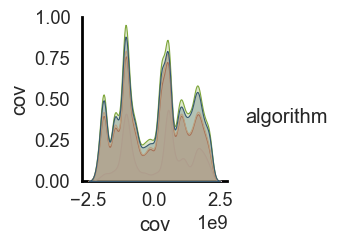

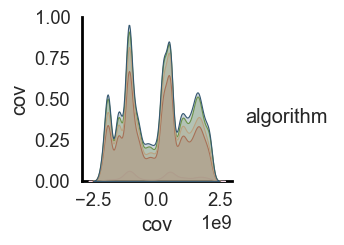

In [10]:


sns.pairplot(cov_all_data,  hue="algorithm")
sns.pairplot(cov_valid_data,  hue="algorithm")


C:\Users\Alena\AppData\Local\Temp\ipykernel_10912\4270977649.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 40, ha='right')


[Text(0, 0, ''),
 Text(1, 0, 'nextflow/Channel'),
 Text(2, 0, 'nextflow/Const'),
 Text(3, 0, 'nextflow/Global'),
 Text(4, 0, 'nextflow/ISession'),
 Text(5, 0, 'nextflow/NF'),
 Text(6, 0, 'nextflow/NextflowMeta'),
 Text(7, 0, 'nextflow/Session'),
 Text(8, 0, 'nextflow/SysEnv'),
 Text(9, 0, 'nextflow/ast/ASTHelpers'),
 Text(10, 0, 'nextflow/ast/GStringToLazyVisitor'),
 Text(11, 0, 'nextflow/ast/LangHelpers'),
 Text(12, 0, 'nextflow/ast/NextflowDSLImpl'),
 Text(13, 0, 'nextflow/ast/NextflowXformImpl'),
 Text(14, 0, 'nextflow/ast/OpXformImpl'),
 Text(15, 0, 'nextflow/ast/TaskCmdXform'),
 Text(16, 0, 'nextflow/ast/TaskCmdXformVisitor'),
 Text(17, 0, 'nextflow/ast/TaskTemplateVarsXformImpl'),
 Text(18, 0, 'nextflow/ast/TaskTemplateVisitor'),
 Text(19, 0, 'nextflow/ast/VariableVisitor'),
 Text(20, 0, 'nextflow/cache/CacheDB'),
 Text(21, 0, 'nextflow/cache/CacheFactory'),
 Text(22, 0, 'nextflow/cache/DefaultCacheFactory'),
 Text(23, 0, 'nextflow/cache/DefaultCacheStore'),
 Text(24, 0, 'nextflo

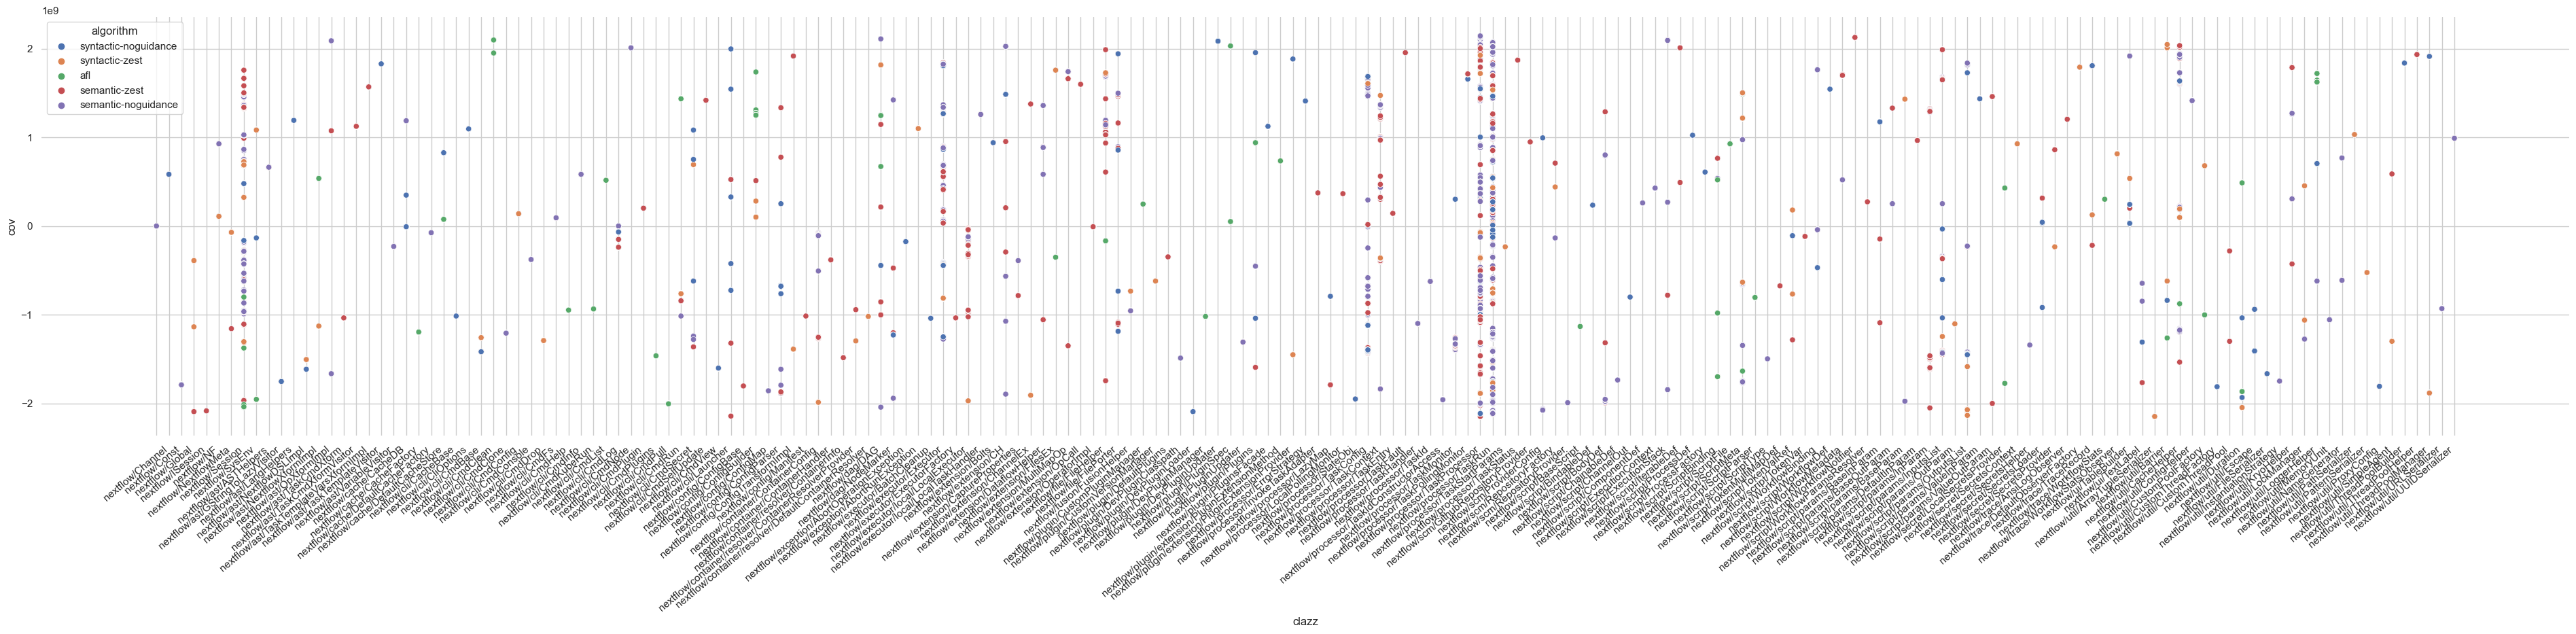

In [24]:
sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(48, 8))
sns.despine(f, left=True, bottom=True)
sorted_data= cov_all_data.sort_values(by=['clazz'])
sns.scatterplot(sorted_data,y='cov',x='clazz',hue="algorithm",ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 40, ha='right')


C:\Users\Alena\AppData\Local\Temp\ipykernel_10912\3124562281.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 40, ha='right')


[Text(0, 0, ''),
 Text(1, 0, 'nextflow/Channel'),
 Text(2, 0, 'nextflow/Const'),
 Text(3, 0, 'nextflow/Global'),
 Text(4, 0, 'nextflow/ISession'),
 Text(5, 0, 'nextflow/NF'),
 Text(6, 0, 'nextflow/NextflowMeta'),
 Text(7, 0, 'nextflow/Session'),
 Text(8, 0, 'nextflow/SysEnv'),
 Text(9, 0, 'nextflow/ast/ASTHelpers'),
 Text(10, 0, 'nextflow/ast/GStringToLazyVisitor'),
 Text(11, 0, 'nextflow/ast/LangHelpers'),
 Text(12, 0, 'nextflow/ast/NextflowDSLImpl'),
 Text(13, 0, 'nextflow/ast/NextflowXformImpl'),
 Text(14, 0, 'nextflow/ast/OpXformImpl'),
 Text(15, 0, 'nextflow/ast/TaskCmdXform'),
 Text(16, 0, 'nextflow/ast/TaskCmdXformVisitor'),
 Text(17, 0, 'nextflow/ast/TaskTemplateVarsXformImpl'),
 Text(18, 0, 'nextflow/ast/TaskTemplateVisitor'),
 Text(19, 0, 'nextflow/ast/VariableVisitor'),
 Text(20, 0, 'nextflow/cache/CacheDB'),
 Text(21, 0, 'nextflow/cache/CacheFactory'),
 Text(22, 0, 'nextflow/cache/DefaultCacheFactory'),
 Text(23, 0, 'nextflow/cache/DefaultCacheStore'),
 Text(24, 0, 'nextflo

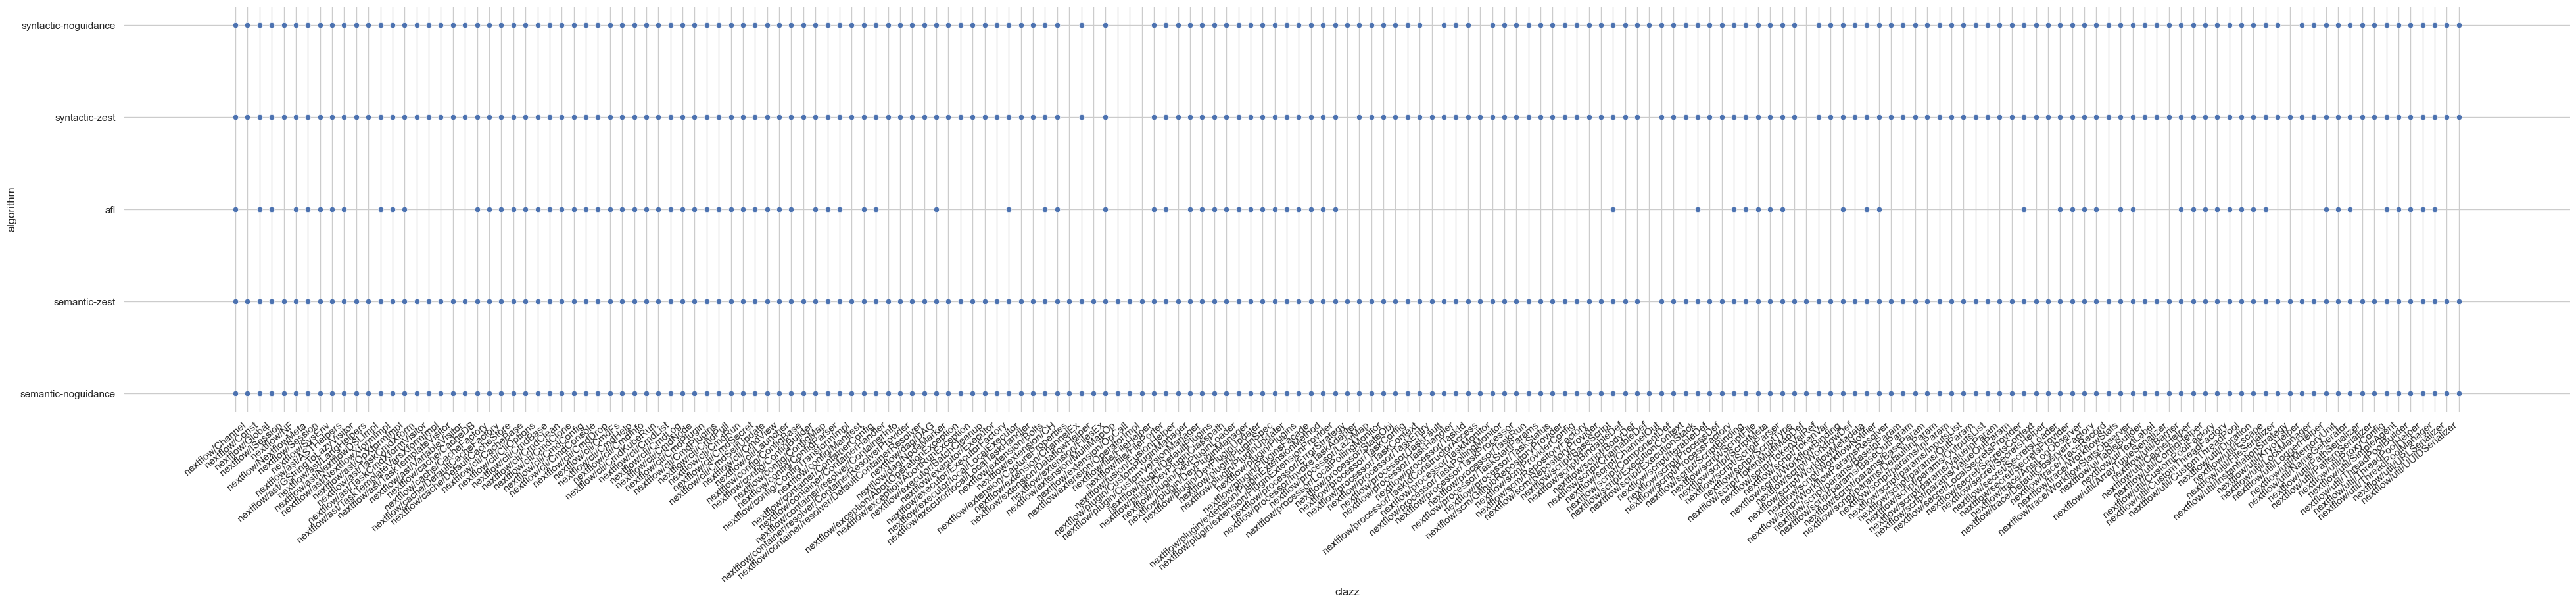

In [35]:
f, ax = plt.subplots(figsize=(48, 8))
sns.despine(f, left=True, bottom=True)
sorted_all_cov=cov_all_data.sort_values(by=['clazz'])
sns.scatterplot(sorted_all_cov,y='algorithm',x='clazz',ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 40, ha='right')


C:\Users\Alena\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Alena\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


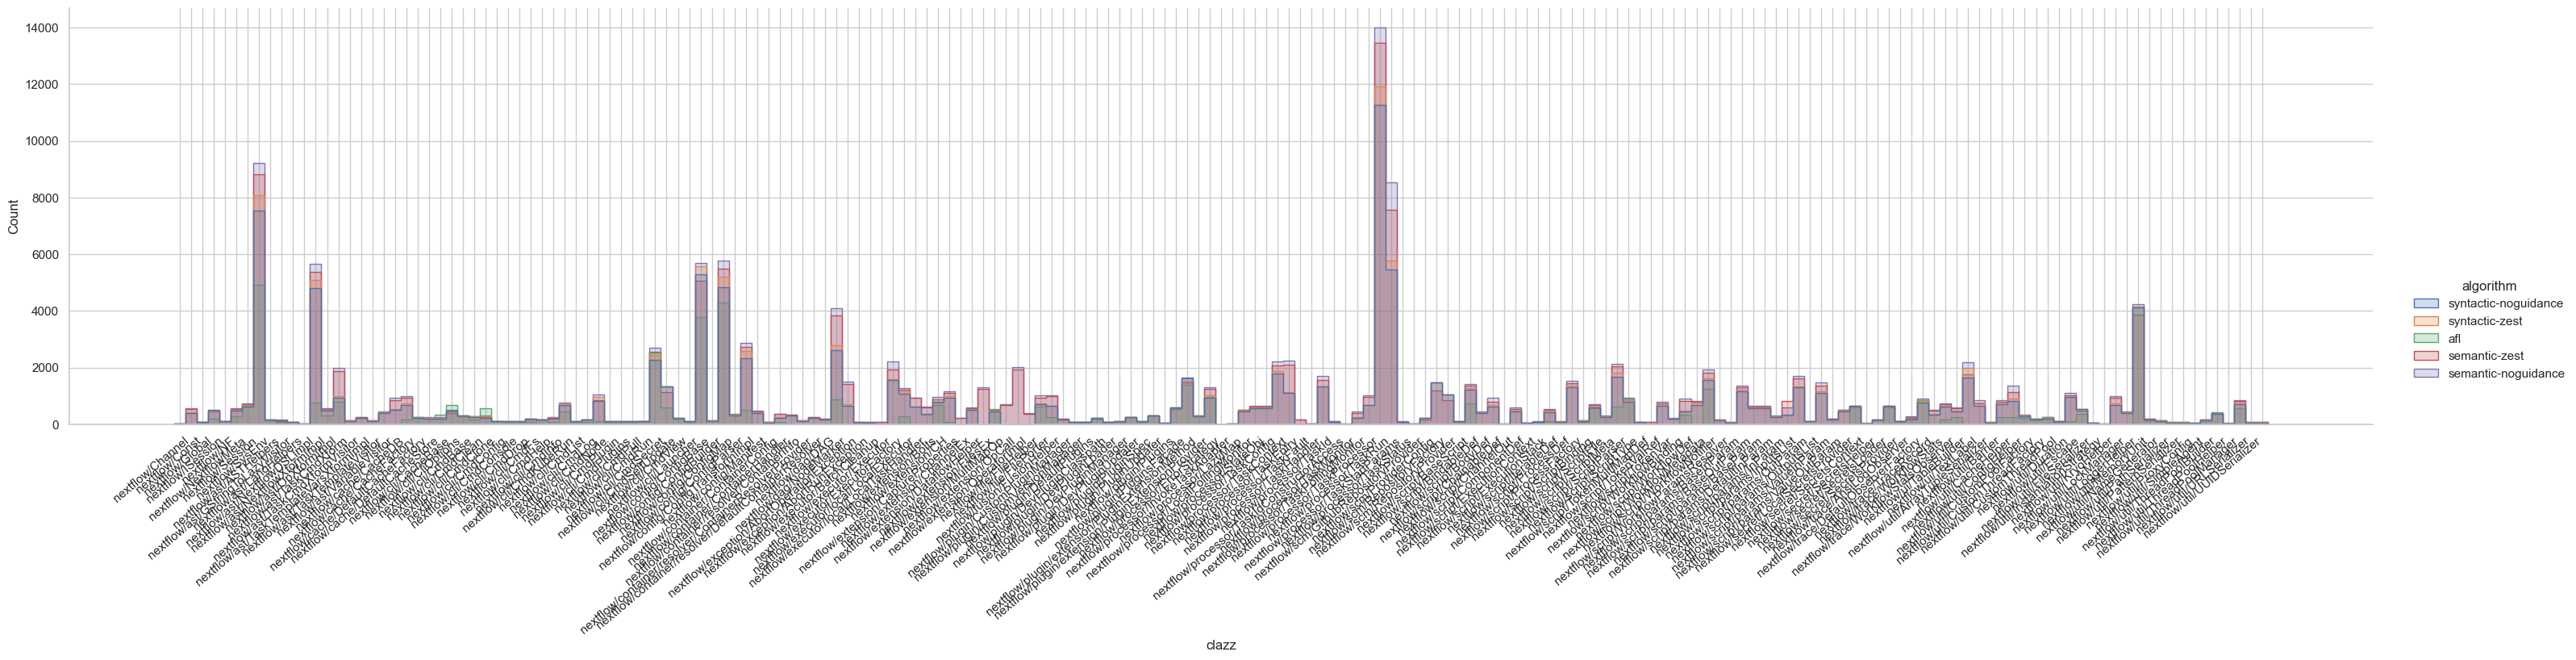

In [34]:
plot = sns.displot(sorted_data,x='clazz',hue="algorithm",height=6, aspect=5,element="step")
plot.tight_layout()

for ax in plot.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(40)
        label.set_ha('right')
#plot.set_xticklabels(plot.get_xticklabels(), rotation = 40, ha='right')

['nextflow/cli/CmdHelper', 'nextflow/cli/PluginAbstractExec', 'nextflow/cli/PluginExecAware', 'nextflow/cli/usageAware', 'nextflow/cloud/CloudSpotTerminationException', 'nextflow/cloud/CloudTransferOptions', 'nextflow/cloud/types/CloudInstance', 'nextflow/cloud/types/CloudInstanceStatus', 'nextflow/cloud/types/CloudInstanceType', 'nextflow/cloud/types/CloudMachineInfo', 'nextflow/cloud/types/CloudSpotPrice', 'nextflow/cloud/types/PriceModel', 'nextflow/conda/CondaCache', 'nextflow/conda/CondaConfig', 'nextflow/config/CascadingConfig', 'nextflow/config/ConfigClosurePlaceholder', 'nextflow/config/ConfigField', 'nextflow/config/PluginsDsl', 'nextflow/container/ApptainerBuilder', 'nextflow/container/ApptainerCache', 'nextflow/container/CharliecloudBuilder', 'nextflow/container/CharliecloudCache', 'nextflow/container/ContainerBuilder', 'nextflow/container/ContainerNameValidator', 'nextflow/container/DockerBuilder', 'nextflow/container/PodmanBuilder', 'nextflow/container/SarusBuilder', 'next

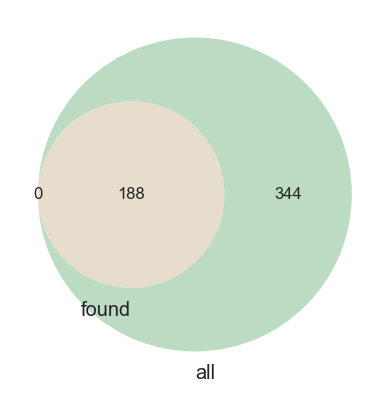

In [56]:
strings_file = "nextflowclasses.txt"


# Create empty output files
found_strings = []
not_found_strings = []
all_classes =[]
cov_data_set = set(cov_all_data['calls'].values)
# Read strings from strings_file and search for them in the DataFrame column 'clazz'
with open(strings_file, 'r') as file:
    for line in file:
        search_string = line.strip()
        all_classes.append(search_string)
        if np.any([search_string in entry for entry in cov_data_set]):
            found_strings.append(search_string)
        else:
            not_found_strings.append(search_string)

print(not_found_strings)
venn2([set(found_strings),set(all_classes)],("found","all"))


In [39]:
from matplotlib_venn import venn2,venn3


def venn2_this(df,column,a,b,on):
# Create subsets for category A and B
    set_a = set(df[df[column].str.contains(a)][on])
    set_b = set(df[df[column].str.contains(b)][on])
    
    # Create a Venn diagram
    venn2([set_a, set_b], (a, b))
    
    # Display the diagram
    plt.title(f'Venn Diagram for Categories {a} and {b} on {on}')
    plt.show()

def venn3_this(df,column,a,b,c,on):
# Create subsets for category A and B
    set_a = set(df[df[column].str.contains(a)][on])
    set_b = set(df[df[column].str.contains(b)][on])
    set_c = set(df[df[column].str.contains(c)][on])
    
    # Create a Venn diagram
    venn3([set_a, set_b, set_c], (a, b,c))
    
    # Display the diagram
    plt.title(f'Venn Diagram for Categories {a} {b} {c} on {on}')
    plt.show()



In [ ]:
venn3_this(cov_valid_data,'algorithm','semantic','syntactic','afl','cov')
venn3_this(cov_all_data,'algorithm','semantic','syntactic','afl','cov')

venn3_this(cov_valid_data,'algorithm','zest','noguidance','afl','cov')
venn3_this(cov_all_data,'algorithm','zest','noguidance','afl','cov')


In [ ]:
venn3_this(cov_valid_data,'algorithm','semantic','syntactic','afl','method')
venn3_this(cov_valid_data,'algorithm','zest','noguidance','afl','method')

venn3_this(cov_all_data,'algorithm','semantic','syntactic','afl','method')
venn3_this(cov_valid_data,'algorithm','semantic','syntactic','afl','method')


In [ ]:
from venn import venn
%matplotlib inline
df=cov_valid_data
column='algorithm'
on='method'
a='semantic-zest'
b='semantic-noguidance'
c='syntactic-zest'
d='syntactic-noguidance'
e='afl'
data = {
    a : set(df[df[column].str.contains(a)][on]),
    b : set(df[df[column].str.contains(b)][on]),
    c : set(df[df[column].str.contains(c)][on]),
    d : set(df[df[column].str.contains(d)][on]),
    e : set(df[df[column].str.contains(e)][on]),
    
}

venn(data)


In [ ]:

cov_all_data[0:3]

In [ ]:
# READ ORIGIANL DATA

original_plot_data=[] # array of original dataframes


for algorithm in ALGORITHM:
    original_data_per_algo = []
    
    for idx in range(0, RANGE):
        path = os.path.join(base_path, f"nextflow-{algorithm}-{idx}", "errorDir")
        if algorithm == "afl":
            path = os.path.join(base_path, f"nextflow-{algorithm}-{idx}","fuzz-results")
        if not os.path.exists(path):
            continue
        #print(f"processing: {path}")

        # plot_data from jqf afl run differs from other 
        if not algorithm == "afl" and os.path.exists(os.path.join(path,"plot_data")): 
            original_data = read_plot_data(path,algorithm)
            if original_data is None:
                continue

            original_data_per_algo.append(original_data)
    
    original_plot_data.extend([d for d in original_data_per_algo])


In [ ]:
# interpolated data

reindexsteps = 20 

time_based_plot_data = [] #dataframe with interpolated runs 
count_based_plot_data = [] #dataframe with interpolated runs

first_idx=0

for df in original_plot_data:
    algorithm = df['algorithm'][0]
    
    x_axis = "# unix_time"
    time_based_data = df.copy().drop_duplicates(
        keep='first', subset=[x_axis])
    
    time_based_data = time_based_data.set_index(x_axis).reindex(
       range(1, time_based_data[x_axis].max(), reindexsteps)).interpolate().reset_index()
    
    #resetting algo because it was overwritten by interpolation
    time_based_data['algorithm'] = [algorithm] * time_based_data.shape[0]
    time_based_plot_data.append( time_based_data)

    
    x_axis = "total_inputs"
    count_based_data = df.copy().drop_duplicates(
        keep='first', subset=[x_axis])
    
    count_based_data = count_based_data.set_index(x_axis).reindex(
       range(0, count_based_data[x_axis].max(), reindexsteps)).interpolate().reset_index()
    #resetting algo because it was overwritten by interpolation
    count_based_data['algorithm'] = [algorithm] * count_based_data.shape[0]
    
    count_based_plot_data.append(count_based_data)

    
    first_idx = first_idx +1
#
time_based_plot_data = pd.concat(time_based_plot_data, ignore_index=True, sort=False)
count_based_plot_data = pd.concat(count_based_plot_data, ignore_index=True, sort=False)
 

In [ ]:
time_based_plot_data


In [ ]:
# rolling mean data

ROLLING_MEAN=40

rolling_time_based_plot_data = [] #dataframe with rolling mean over all runs
rolling_count_based_plot_data = [] #dataframe with rolling mean over all runs

complete_data_frame = pd.concat(original_plot_data, ignore_index=True, sort=False)

for algorithm in ALGORITHM:
    data_per_algo = complete_data_frame[complete_data_frame['algorithm'] == algorithm]

    if data_per_algo is None or len(data_per_algo) == 0: continue

    rolling_time_based_data_per_algo = data_per_algo.sort_values(by=['# unix_time'])
    rolling_time_based_data_per_algo = add_rolling_mean(rolling_time_based_data_per_algo, ROLLING_MEAN)
    rolling_time_based_plot_data.append(rolling_time_based_data_per_algo)

    rolling_count_based_data_per_algo = data_per_algo.sort_values(by=['total_inputs'])
    rolling_count_based_data_per_algo = add_rolling_mean(rolling_count_based_data_per_algo, ROLLING_MEAN)
    rolling_count_based_plot_data.append(rolling_count_based_data_per_algo)



 
rolling_time_based_plot_data = pd.concat(rolling_time_based_plot_data, ignore_index=True, sort=True)
rolling_count_based_plot_data = pd.concat(rolling_count_based_plot_data, ignore_index=True, sort=True)



In [ ]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + 10
            value = str(int(p.get_height()))
            ax.text(_x, _y, value, ha="center")

    if isinstance(axs, np.ndarray):
        for _, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

def generate_total_coverage_bar(data: Dict[str, List[Any]]):
    axis = sns.barplot(x="type", y="value", hue="algo", data=data)
    show_values_on_bars(axis)
    fig = axis.get_figure()
    #fig.savefig(path)
    #fig.clf()
    fig.show()



In [ ]:


generate_total_coverage_bar(cov_data_count)


In [ ]:
def generate_plot_data_base(data: pd.DataFrame, rolling_data:pd.DataFrame, x_axis: str, y_axis: str,  errorbarname: str = 'se'):
    print(x_axis, y_axis)
    fig, ax1 = plt.subplots(figsize=(12,8))
    ax2 = ax1.twinx()

    if errorbarname == 'se':
        lineplot1 = sns.lineplot(x=x_axis, y=y_axis, hue='algorithm', errorbar="se", hue_order=sorted(data['algorithm'].unique()), data=data, ax=ax1)
   
    elif errorbarname == 'sd':
        lineplot1 = sns.lineplot(x=x_axis, y=y_axis, hue='algorithm', errorbar=("sd",95), hue_order=sorted(data['algorithm'].unique()), data=data, ax=ax1)    

    lineplot2 = sns.lineplot(x=x_axis, y=f"rolling_{ROLLING_MEAN}_{y_axis}", hue='algorithm', errorbar=None, hue_order=sorted(data['algorithm'].unique()), data=rolling_data, ax=ax2, linestyle="dotted")

    ax1.set_xlabel(x_axis)
    ax1.set_ylabel(y_axis)
   # ax2.set_ylabel(f"rolling_{ROLLING_MEAN}_{y_axis}")

    fig = ax2.get_figure()
    #fig.show()


In [ ]:
errorbrar = 'se'

generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "valid_covered_probes",errorbrar)
generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "all_covered_probes", errorbrar)
generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "total_inputs", errorbrar)


In [ ]:

generate_plot_data_base(count_based_plot_data, rolling_count_based_plot_data, "total_inputs", "valid_covered_probes", errorbrar)
generate_plot_data_base(count_based_plot_data, rolling_count_based_plot_data, "total_inputs", "valid_covered_probes", errorbrar)
